<a href="https://colab.research.google.com/github/good0neighbour/ESTCampAI/blob/main/%EC%96%B8%EC%96%B4%EC%A7%80%EB%8A%A5(%ED%97%88%EA%B9%85%ED%8E%98%EC%9D%B4%EC%8A%A4_NLP)/ex02_BERTopic_%EA%B8%B0%EB%B0%98_%ED%85%8D%EC%8A%A4%ED%8A%B8%EB%A7%88%EC%9D%B4%EB%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/MyDrive/ESTCampAI/언어지능(허깅페이스_NLP)

/content/drive/MyDrive/ESTCampAI/언어지능(허깅페이스_NLP)


In [2]:
# transformers[torch] 설치
!pip -q install transformers[torch]

In [3]:
!pip show transformers

Name: transformers
Version: 4.57.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.12/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft, sentence-transformers


## 목표
- 사전학습 되어있는 모델만 활용하여 [요약] -> [임베딩] -> [클러스터링(비지도)] -> [감성분석]을 포함하는 통합 분석 파이프라인 구현

## 시나리오

### 배경
- “K-인사이트”는 <u>월간 **50만 건** 이상의 SNS 대화를 처리하는 기업용 분석 플랫폼</u>  
- AI Hub의 한국어 SNS 데이터(“미용과건강”, “식음료”, “일과직업”) 기반으로 사용자의 대화 내용을 <u>자동 탐지·분류</u>해야 함  
- 긴 대화 로그에는 <u>메타정보·반복 발화·잡음</u>이 포함되어 있어, <u>핵심 주제 파악</u>과 <u>감성 분석</u>이 어려움  
- <u>요약 → 임베딩 → 클러스터링(군집화) → 감성분석</u>의 통합 파이프라인으로 <u>자동 인사이트 생성</u>이 필요  

```python
# 주요 이해관계자
- 데이터 사이언스팀 : 통합 분석 파이프라인 개발·유지보수  
- 제품 기획팀       : 사용자 인사이트 기반 서비스 기획  
- 운영팀           : 실시간 토픽·감성 모니터링 시스템 운영  
- 마케팅팀         : 토픽별 감성 결과로 캠페인 전략 수립  
```

> AI Hub - 한국어 SNS 데이터셋 링크
> - https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=114
> - JSON 형식으로 제공되며, 각 대화에 메타정보와 발화(utterance) 리스트(body)가 포함
> - 실습상 데이터셋이 방대하여, 실습상 `미용과건강`, `식음료`, `일과직업` 만 활용
>    - 기존 라벨 : 개인관계, 미용과건강, 상거래(쇼핑), 시사교육, 식음료, 여가생활, 일과직업, 주거와 생활, 행사

In [4]:
# 압축 파일 해제
# !unzip -q ./data/Korean\ SNS.zip -d ./data/Korean_SNS

## 1. 데이터준비

In [5]:
import os, json, re
# os: 운영체제 기능을 활용할 수 있는 라이브러리
# - 입출력 제어
# - 파일 제어 기능

# json: 데이터 폴더 내부에 json 파일 존재, 해당 확장자 형태의 파일을 다루기

# re: 정규표현식, 문자열 처리 해주는 기능

In [6]:
# 경로 설정
train_dir = './data/Korean_SNS/Training/'
val_dir = './data/Korean_SNS/Validation/'

# 라벨값 크기 제어
# 원본 라벨 크기: train - 353979 개, val - 44249개
# - 실습하기에는 너무 방대한 양이라 제한해서 진행해보자
limit_label = 200

- json 데이테 로드, 샘플 하나 불러와서 간단하게 확인해보기

In [7]:
# 샘플로 사용할 파일 한 개 선택하기
sample_fname = os.listdir(train_dir)[0]
sample_path = os.path.join(train_dir, sample_fname)
sample_path

'./data/Korean_SNS/Training/미용과건강.json'

In [8]:
# json 파일 내부를 확인해보자
with open(sample_path, 'r', encoding = 'utf-8') as f:
  dataset = json.load(f)

dataset.keys()

dict_keys(['numberOfItems', 'data'])

In [9]:
# data 접근해보기
sample = dataset['data'][0]
sample

{'header': {'dialogueInfo': {'dialogueID': '403d6d5f-6241-505b-87a0-fb755d666cf6',
   'numberOfParticipants': 2,
   'numberOfUtterances': 18,
   'numberOfTurns': 6,
   'type': '일상 대화',
   'topic': '미용과 건강'},
  'participantsInfo': [{'participantID': 'P01',
    'gender': '여성',
    'age': '20대',
    'residentialProvince': '인천광역시'},
   {'participantID': 'P02',
    'gender': '여성',
    'age': '20대',
    'residentialProvince': '경기도'}]},
 'body': [{'utteranceID': 'U1',
   'turnID': 'T1',
   'participantID': 'P01',
   'date': '2017-08-13',
   'time': '15:03:00',
   'utterance': '마니아프세여???'},
  {'utteranceID': 'U2',
   'turnID': 'T1',
   'participantID': 'P01',
   'date': '2017-08-13',
   'time': '15:04:00',
   'utterance': '#@시스템#사진#'},
  {'utteranceID': 'U3',
   'turnID': 'T1',
   'participantID': 'P01',
   'date': '2017-08-13',
   'time': '15:04:00',
   'utterance': '흙흙흙'},
  {'utteranceID': 'U4',
   'turnID': 'T2',
   'participantID': 'P02',
   'date': '2017-08-13',
   'time': '15:04:00',
  

In [10]:
# body 내부의 실제 대화 문장, 단어에 접근해보기
sample['body'][0]['utterance']

'마니아프세여???'

In [11]:
# 대화의 모든 발화(utterance)를 공백으로 연결하여 하나의 텍스트를 생성해보자
sample_text = " ".join(turn['utterance'] for turn in sample['body'])
sample_text

'마니아프세여??? #@시스템#사진# 흙흙흙 아 개피곤 ㅋㅋ 님 괜찮아여? 왜 먹고 먹고 머고만 햇는데 몸이 무겁지 걸은것도 별로 없는데 몰라여 응가싸서 그런가 고되다 똥싸서 몸무게 빠졋나 아삐건해 미틴ㅋㅋㅋㅋㅋㅋ 진짜 7-800그람 빠짐 나 몸이 너무 무거워서 몸무게 쟀는데 빠져서 놀랏어 너무 무서워'

In [12]:
# 각각의 모든 대화를 하나의 문장으로 만들어보기
# json - 3개
# 각각의 대화
# 대화 내부 발화 여러개 존재

from tqdm.auto import tqdm
# 함수가 실행되는 상태를 로딩바처럼 출력해주는 기능

def load_and_normalize(dir_path):
  """
  지정한 디렉토리(dir_path) 내 모든 JSON 파일을 순회하며,
  각 대화(dialog)의 'body' 필드에 담긴 발화(utterance)를 하나의 문서(text)로 연결한 뒤
  리스트로 반환하는 함수

  인자(dir_path) : JSON 파일들이 들어 있는 폴더 경로
  반환(corpus) : 대화별로 병합된 텍스트 리스트
  """

  corpus = [] # 결과를 담을 빈 리스트

  # 해당 폴더 내 모든 이름을 가져와서 반복
  for fname in tqdm(os.listdir(dir_path), desc = f"Loading {dir_path}"):
    file_path = os.path.join(dir_path, fname) # 각 파일의 전체 경로 생성 부분
    count = 0                                                 # 라벨당 문서 수 카운터 초기화

    # json 파일 로드
    with open(file_path, "r", encoding = 'utf-8') as f:
      dataset = json.load(f) # 외부 파일 확장자가 json, json 구조 파악

    # dataset -> 대화 내용 (dialog)
    for dialog in tqdm(dataset['data'], desc = f"proprecessing {fname}"):
      # 라벨당 제한 횟수(개수) 초과 시 반복 종료
      if count >= limit_label:
        break

      # 각 대화(dialog)에서 발화부분 접근 -> 하나의 문장 셋팅
      text = " ".join(turn['utterance'] for turn in dialog['body'])

      # 결과적으로 하나의 문장으로 바뀐 대화를 저장해줘야하는 상황
      corpus.append(text) # 빈 리스트에 문장을 추가
      count += 1               # 문서 카운터 1씩 증가, count = count + 1
    return corpus

In [13]:
# train, val 경로 - 적용
train_corpus = load_and_normalize(train_dir)
val_corpus = load_and_normalize(val_dir)

Loading ./data/Korean_SNS/Training/:   0%|          | 0/3 [00:00<?, ?it/s]

proprecessing 미용과건강.json:   0%|          | 0/99383 [00:00<?, ?it/s]

Loading ./data/Korean_SNS/Validation/:   0%|          | 0/3 [00:00<?, ?it/s]

proprecessing 식음료.json:   0%|          | 0/18328 [00:00<?, ?it/s]

In [14]:
# 불러온 데이터 수 및 샘플 출력
print(f">>> train 문서의 수: {len(train_corpus)}")
print(f">>> val 문서의 수: {len(val_corpus)}")
print(f">>> 샘플 문서 3개 확인: ")
for i in range(3):
  # 앞의 100자씩만 출력하면서 3개의 문서를 확인해보자
  print(f"[train 문서 {i+1}] {train_corpus[i][:40]}...")
  print(f"[val 문서 {i+1}] {val_corpus[i][:40]}...\n")

# 문장의 길이가 길다면, 주요 의미를 내포한 단어를 쉽게 확인하기 어려움
# 긴 문장에 대해서 요약 처리 추가 해주면 어떨까?

>>> train 문서의 수: 200
>>> val 문서의 수: 200
>>> 샘플 문서 3개 확인: 
[train 문서 1] 마니아프세여??? #@시스템#사진# 흙흙흙 아 개피곤 ㅋㅋ 님 괜찮아여?...
[val 문서 1] 애네 꼬치도 하네 맛나겟다 우리도 예전엔 햇는데 지금은 딱 차례상에 올리...

[train 문서 2] 구냥 기른거같은데... ㅋ켘캨ㅋㅋㅋ ㅋㅋㅋㅋㅋㅋ알지 뭔날린디 #@이름# ...
[val 문서 2] 자기 먹고찌푼걸루 ㅎㅎㅎㄹ 열라면사서 먹어여겟군! 소시지도 팡팡 넣구 응...

[train 문서 3] 다자기랑먹느라찐디 아닌데요!! 평일에 9시에 저녁을먹눈데 당연히찌죠 아닌...
[val 문서 3] 옥수수 먹고싶다 아까자기전에 기영이처럼 옥수수 상상함 ㅋㅋㅋㅋㅋ 옥수수....



## 2. 대화요약
- 문서 길이 절감: 요약을 통해 핵심 내용만 남기면 후속 임베딩, 토픽 모델링 연산 속도를 높일 수 있음
- 노이즈 제거: 불필요한 대화(인사, 중복 발화 등)를 압축하여 중요한 주제어 비중을 높임
- 토픽 명확화: 긴 대화 대신 요약문을 사용하면 BerTopic이 더 뚜렷한 주제어를 학습할 수 있음 -> 확실한 카테고리로 문장을 구분해나갈 수 있음

In [15]:
import torch # 토치 형태의 텐서를 사용함
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# AutoTokenizer: 다양한 사전학습 토크나이저를 쉽게 로드 기능
# AutoModelForSeq2SeqLM : Seq2Seq(입력 -> 출력) 구조의 언어모델 로드하는 기능 ( 요약, 번역 등 과제 해결하는 모델)

### T5
- T5 = Text-to-Text Transfer Transformer  
입력(input)과 출력(output)을 모두 텍스트 형태로 다루는 모델입니다.
번역, 요약, 질의응답, 분류, 문장 생성 등 모든 작업을 하나의 통합 프레임워크로 처리할 수 있어요.

- 구조적으로는 “Encoder-Decoder Transformer”  
T5는 Transformer 구조를 그대로 사용하지만,   
BERT처럼 인코더(encoder) 부분은 입력 문장 이해 담당
GPT처럼 디코더(decoder) 부분은 출력 문장 생성 담당  
즉, BERT + GPT의 장점을 결합한 형태입니다.  

- 요약 모델(KoT5) 허깅페이스 : https://huggingface.co/psyche/KoT5-summarization
- KoT5: 한국어 T5(Text-to-Text Transfer Transformer) 모델  
  
> #### 사전학습 정보 (Pre-training)
- **코퍼스**  
  - 위키백과, 신문기사 등 23개 출처에서 수집한 총 939 GB 원시 데이터 → 전처리 후 약 42 GB 말뭉치 사용
- **체크포인트**  
  - KoT5-Small: 6 layers, hidden_size=512, 60M 파라미터  
  - KoT5-Base: 12 layers, hidden_size=768, 220M 파라미터

> #### 파인튜닝(Fine-tuning)
- **데이터셋**  
  - AI-Hub “SNS 요약” 데이터셋  
- **디코딩 설정**  
  - greedy decoding  
  - 최대 길이 `max_length=256`, `repetition_penalty=2.0` 적용
  - repetition_penalty : 같은 토큰이 반복적으로 나오면 penalty를 적용해서 해당 토큰의 logit을 낮춰줌 (값은 1.0 이상이며, 값이 클 수록 penalty를 세게 적용)

- T5 아키텍처
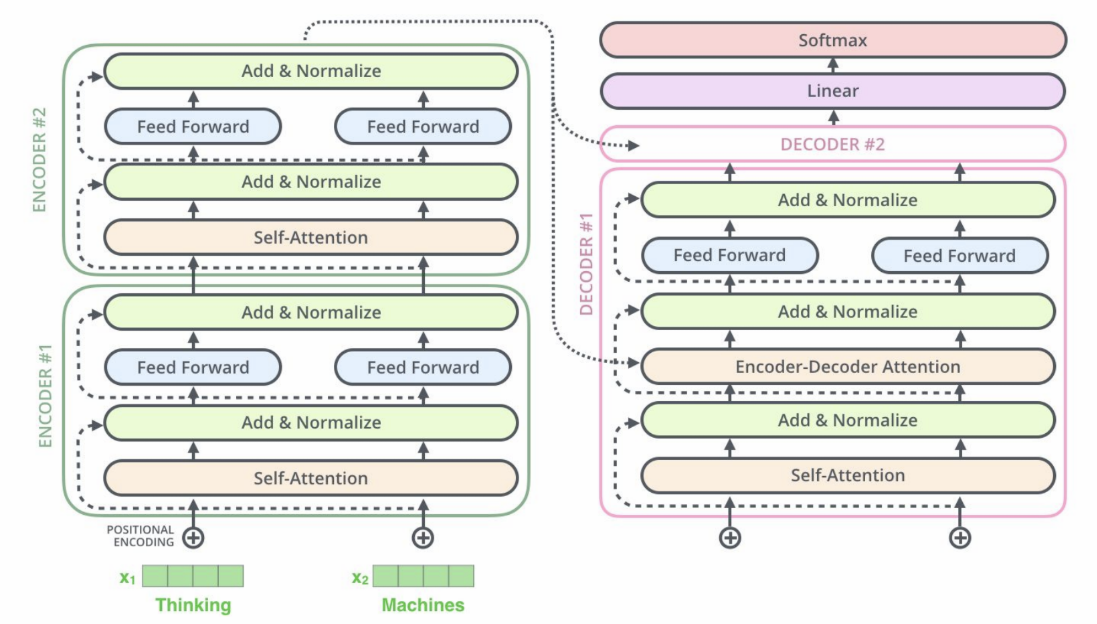

In [16]:
# 사전학습 요약 모델 명
model_name = 'psyche/KoT5-summarization'

In [17]:
# 요약 모델 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

In [18]:
# 지정된 디바이스 확인 ( gpu 연결 확인 )
# cuda : gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print('사용하는 device:', device)

사용하는 device: cuda


In [19]:
# 요약 모델 연결 - cuda(gpu)로 모델을 명확하게 설정
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
model
# .to(device): 지정된 디바이스(일반적으로 gpu)로 텐서 이동

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

- 샘플 텍스트로 용약하는 모델 사용해보기

In [20]:
# 샘플 텍스트 준비
sample_text = train_corpus[0]
sample_text

'마니아프세여??? #@시스템#사진# 흙흙흙 아 개피곤 ㅋㅋ 님 괜찮아여? 왜 먹고 먹고 머고만 햇는데 몸이 무겁지 걸은것도 별로 없는데 몰라여 응가싸서 그런가 고되다 똥싸서 몸무게 빠졋나 아삐건해 미틴ㅋㅋㅋㅋㅋㅋ 진짜 7-800그람 빠짐 나 몸이 너무 무거워서 몸무게 쟀는데 빠져서 놀랏어 너무 무서워'

In [21]:
# 입력 텍스트 토큰화 및 gpu로 이동
inputs = tokenizer(
    sample_text,          # 토큰화 대상 문자열
    truncation = True,    # 길이 초과 시 잘라내기
    max_length = 512,     # 최대 토큰 길이 512 허용
    return_tensors = 'pt' # 데이터 처리 난 후 텐서의 형태
).to(device)              # 토큰화된 데이터가 gpu 메모리로 할당

# input_ids: 토큰화 되고 난 후의 단어에 매칭된 ID 숫자값
# attention_mask: 1로 작성된 것은 실제로 문장 내에서 토큰화된 데이터라는 설명
#                 0로 작성된 것은 문장 내에 포함되지 않은 데이터라는 의미

In [22]:
# 요약 시퀀스 생성
# 모델 -> 요약 명령 시키기(생성)
outputs = model.generate(
    **inputs,
    max_length = 100,      # 요약문의 최대 토큰 길이 설정
    min_length = 20,       # 요약문의 최소 토큰 길이 설정
    num_beams = 4,         # 빔 서치 수: 매 단계마다 가장 가능성 높은 4개 후보 토큰을 유지하며 탐색을 하는 부분
    early_stopping = True, # 조기 학습 중단: 중단 여부를 확인시킬 수 있도록 조기학습 중단을 연결
                           # EOS(문장 끝)을 마나면 더이상 문장을 생성하지 않도록 하게 하는 설정 (즉시 생성 중단)
                           # 불필요한 패딩, 중복 방지
    length_penalty = 2.0  # 길이 패널티 : 생성 길이에 가중치를 주어 스코어를 조정하는 설정
                          # 값 > 1.0 : 긴 시퀀스일수록 패널티 값이 짧은 출력을 선호하도록 함
                          # 값 < 1.0 : 긴 시퀀스에 대한 패널티 값이 작아져 긴 출력을 유도하도록 함
)

In [23]:
# 요약 (인코딩) -> 문자로 다시 변경(디코딩)
summary = tokenizer.decode(
    outputs[0],                # 생성된 토큰 ID목록 연결 (1개 문장 인덱스에 접근)
    skip_special_tokens = True # <pad>, <eos> 등 패딩 부분, 끝값에 대한 인식을 위한 특수 토큰을 제거하라는 의미
)

summary

'왜 먹고 먹고만 햇는데 몸이 무겁지 걸은것도 별로 없는데 몰라여 응가싸서 그런가 고되다 똥싸서 몸무게 빠졋나 아삐건해 미틴 진짜 7-800그람 빠짐 나 몸이 너무 무거워서 몸무게 쟀는데 빠져서 놀란다'

In [24]:
# 텍스트 요약 함수 정의해보자
def summarize(text):
  """
  입력 텍스트를 KoT5모델로 요약하는 기능(함수)
  """

  # 1) 입력 토큰화 및 gpu 이동
  inputs = tokenizer(
      text,          # 토큰화 대상 문자열
      truncation = True,    # 길이 초과 시 잘라내기
      max_length = 512,     # 최대 토큰 길이 512 허용
      return_tensors = 'pt' # 데이터 처리 난 후 텐서의 형태
  ).to(device)

  # 2) 요약문 생성(모델) - generate
  outputs = model.generate(
      **inputs,
      max_length = 100,      # 요약문의 최대 토큰 길이 설정
      min_length = 20,       # 요약문의 최소 토큰 길이 설정
      num_beams = 4,         # 빔 서치 수: 매 단계마다 가장 가능성 높은 4개 후보 토큰을 유지하며 탐색을 하는 부분
      early_stopping = True, # 조기 학습 중단: 중단 여부를 확인시킬 수 있도록 조기학습 중단을 연결
                            # EOS(문장 끝)을 마나면 더이상 문장을 생성하지 않도록 하게 하는 설정 (즉시 생성 중단)
                            # 불필요한 패딩, 중복 방지
      length_penalty = 2.0  # 길이 패널티 : 생성 길이에 가중치를 주어 스코어를 조정하는 설정
                            # 값 > 1.0 : 긴 시퀀스일수록 패널티 값이 짧은 출력을 선호하도록 함
                            # 값 < 1.0 : 긴 시퀀스에 대한 패널티 값이 작아져 긴 출력을 유도하도록 함
  )

  # 3) 디코드 과정의 코드
  summary = tokenizer.decode(outputs[0], skip_special_tokens = True)
  return summary

In [25]:
# train 샘플 요약
summaries = [summarize(doc) for doc in tqdm(train_corpus, desc = 'Summarizing...')]
summaries

Summarizing...:   0%|          | 0/200 [00:00<?, ?it/s]

['왜 먹고 먹고만 햇는데 몸이 무겁지 걸은것도 별로 없는데 몰라여 응가싸서 그런가 고되다 똥싸서 몸무게 빠졋나 아삐건해 미틴 진짜 7-800그람 빠짐 나 몸이 너무 무거워서 몸무게 쟀는데 빠져서 놀란다',
 '알고 뭔날린디 #@이름# 털을 보면 관리를 해서 스탈이구나 싶은데 #@이름#는 그냥인지 스타일인지 헷갈림 그냥인느낌이엇어 엌 마구 기르는느낌 그칰',
 '평일에 9시에 저녁을 먹는데 당연히찌가 아닌데요? 데이트할때마다 배터지게 먹어서 그런건데여?',
 '무게가 안 줄어서 몸무게가 안 줄어서? 무게는 중요한게 아니야 나 몸무게 체크 안 해 허허허',
 '가을이 되면 단발을 하고 싶은데 후회 천퍼 할 구 알아서 그냥 있는다....... 나도 근데 가을되면 단발 하고 싶은데 과연 후회 천퍼 할 구 알아서 그냥 있는다.......',
 '어제 몸이 안좋아서 낮에 내리 자고 한밤에 일어나서 새벽에 잤어 수술 빨리 해야긋다 무섭다  그래도 안해도 되는디 얼릉해 온몸이 너무 가렵길래 어제 가려움증 약을 사와서 먹으니 낫네',
 '오빠 정처기 시험이 4월 27일인데 웅 토익이 4월 28일 시험이네 도랏나..',
 '식단관리하면서 너무 부작용이 많아 식단관리  소요없어 그냥 이거 그래도 안하는 것보단 나은거 아냐?',
 '  12분걸리는 넬기가 3분만에 잡는다구! 어제보단 많이 나아짐 이양 다행쓰 예?',
 '오빠도 코로나 검사한거 오빠 양성이면 어머니도 백퍼일텐데 옹옹 했지  걱정이다 나도 걱정은 되는데 안걸렷을꺼얌 재채기는 에어컨키고 살아서 감기얌 증상이야 그렇다치고 아닐꺼야 무증상도 있어서  근데 코로나 걸리면 휴유증이 심해서 그게 걱정이야 휴유증도 있대?',
 '그런데 이게 나오면 대부분 1차 단계여서 고위험군 아니먼 약물하면 된뎅 쩝스바리 면역력관리 잘해야 하는뎅 그래도 좀 그렇잔아 찜찜라지 걱정이군',
 '손가락이 부러질정돈 아닌데 너무 가늘어서  그정돈아님 손이 길어서그렇지 얇진않아 길어서 얇아보이는건가 ',
 '사랑니가 아프긴한데 통각이 없잖아 통각이 없

In [26]:
import pickle
# summaries
# summaries 데이터 저장
# with open('./data/ko_sns.pickle', 'wb') as f:
#   pickle.dump(summaries, f)
# - 파이썬 원본 자료구조를 유지하여 데이터를 파일로 저장하는 모듈(기능)
# 파일 저장 후 불러와서 수업 연계 (10.30)
with open('./data/ko_sns.pickle', 'rb') as f:
  summaries = pickle.load(f)
summaries

['왜 먹고 먹고만 햇는데 몸이 무겁지 걸은것도 별로 없는데 몰라여 응가싸서 그런가 고되다 똥싸서 몸무게 빠졋나 아삐건해 미틴 진짜 7-800그람 빠짐 나 몸이 너무 무거워서 몸무게 쟀는데 빠져서 놀란다',
 '알고 뭔날린디 #@이름# 털을 보면 관리를 해서 스탈이구나 싶은데 #@이름#는 그냥인지 스타일인지 헷갈림 그냥인느낌이엇어 엌 마구 기르는느낌 그칰',
 '평일에 9시에 저녁을 먹는데 당연히찌가 아닌데요? 데이트할때마다 배터지게 먹어서 그런건데여?',
 '무게가 안 줄어서 몸무게가 안 줄어서? 무게는 중요한게 아니야 나 몸무게 체크 안 해 허허허',
 '가을이 되면 단발을 하고 싶은데 후회 천퍼 할 구 알아서 그냥 있는다....... 나도 근데 가을되면 단발 하고 싶은데 과연 후회 천퍼 할 구 알아서 그냥 있는다.......',
 '어제 몸이 안좋아서 낮에 내리 자고 한밤에 일어나서 새벽에 잤어 수술 빨리 해야긋다 무섭다  그래도 안해도 되는디 얼릉해 온몸이 너무 가렵길래 어제 가려움증 약을 사와서 먹으니 낫네',
 '오빠 정처기 시험이 4월 27일인데 웅 토익이 4월 28일 시험이네 도랏나..',
 '식단관리하면서 너무 부작용이 많아 식단관리  소요없어 그냥 이거 그래도 안하는 것보단 나은거 아냐?',
 '  12분걸리는 넬기가 3분만에 잡는다구! 어제보단 많이 나아짐 이양 다행쓰 예?',
 '오빠도 코로나 검사한거 오빠 양성이면 어머니도 백퍼일텐데 옹옹 했지  걱정이다 나도 걱정은 되는데 안걸렷을꺼얌 재채기는 에어컨키고 살아서 감기얌 증상이야 그렇다치고 아닐꺼야 무증상도 있어서  근데 코로나 걸리면 휴유증이 심해서 그게 걱정이야 휴유증도 있대?',
 '그런데 이게 나오면 대부분 1차 단계여서 고위험군 아니먼 약물하면 된뎅 쩝스바리 면역력관리 잘해야 하는뎅 그래도 좀 그렇잔아 찜찜라지 걱정이군',
 '손가락이 부러질정돈 아닌데 너무 가늘어서  그정돈아님 손이 길어서그렇지 얇진않아 길어서 얇아보이는건가 ',
 '사랑니가 아프긴한데 통각이 없잖아 통각이 없

## 3.임베딩 모델 선택
- 텍스트를 수치 벡터(임베딩)로 변환해야 **<U>유사도**</U> 계산이나, **<U>클러스터링**</U>이 가능

> #### **<U>SBERT(Sentence-BERT)**</U> 활용
> - BERT 모델을 **<U>문장 임베딩(`Sentence Embedding`)을 생성하는 모델**</U>로 활용할 수 있도록 Fine-tuning하는 방법(또는 모델명) 을 의미
> - **<U>문장 간 의미적 관계를 잘 보존하는 임베딩을 제공**</U>

- `Sentence embedding` : 문장 정보를 벡터 공간의 위치로 표현한 값
- 문장을 벡터 공간에 배치함으로서 **<U>문장 간 비교, 클러스터링, 시각화 등 다양한 분석 기법**</U>을 이용할 수 있는 것이 장점

In [27]:
# train_corpus : 원본
# summaries : 요약
# --> 벡터화(임베딩)

In [28]:
from sentence_transformers import SentenceTransformer # SBERT 임베딩 모델 로드하는 코드

# sentence_transformers : colab 내장 되어 있음
# !pip -q install sentence-transformers

### 한국어 특화 Sentence-BERT (SBERT)
- 사용 모델 허깅페이스 : https://huggingface.co/snunlp/KR-SBERT-V40K-klueNLI-augSTS
- 문장·단락을 768차원 밀집 벡터로 변환해 클러스터링, 의미 검색 등에 활용 가능

> #### 사전학습 정보 (Pre-trained BERT)
> - **<U>KR-BERT-V40K**</U> :  WordPiece 토크나이저 (어휘 사전 크기 40K)  
> - 문장 내 토큰별 Contextualized 벡터(`컨텍스츄얼라이즈드`, 상황에 맞는)를 `Average Pooling`으로 문장 벡터 생성
> - SBERT의 `Average Pooling` : 문장 전체 토큰의 맥락을 고르게 반영하여 **<U>한 개의 벡터로 만드는 과정**</U>

> #### 파인튜닝 (Fine-tuning)
> - **<U>Siamese 네트워크 구조**</U>
>    1. 두 문장 벡터를 분류기(Classifier)에 입력  
>    2. 문장 간 관계 반영하도록 BERT 가중치 파인튜닝
>    - 임베딩 공간 자체가 "유사한 것끼리 모이고, 다른 것은 멀어지도록" 학습되려면, 문장 쌍을 동시에 보고 비교하는 Siamese 구조가 필요함  
> - **<U>학습 데이터**</U>  
>    - KLUE-NLI (한국어 자연어 추론)  
>    - KorSTS(한국어 STS) 데이터셋을 in-domain 전략으로 증강

#### Siames Neural Network(샴 네트워크)의 구조

> **구조 개요**
> - 왼쪽에 서로 다른 두 입력(예: 두 이미지, 두 문장)이 들어감
> - 중앙의 네트워크 블록(회색 박스)은 **동일한 가중치**를 공유하며(Weight Sharing) 두 입력을 각각 처리
> - 오른쪽에서 각 입력으로부터 나온 **임베딩 벡터**(Embedding 1, Embedding 2)를 비교하여 거리를 계산(Distance)
> - 마지막으로 "두 입력이 같은 클래스인가?"를 확률(Probability)로 출력

> **세부 동작 흐름**
> 1. **Input 1 / Input 2**
>    - 비교·판단할 대상 데이터
> 2. **Siamese subnetwork**
>    - 두 입력에 **같은** 모델(같은 구조, 같은 가중치) 적용
>    - 입력마다 별도로 통과시키지만, 학습 시 가중치는 공유
> 3. **Embedding 1 / Embedding 2**
>    - 각 서브넷워크의 마지막 레이어에서 추출된 고차원 특징 벡터(예: 128차원, 768차원)
> 4. **Distance 계산**
>    - 두 임베딩 벡터 간 유클리드 거리(Euclidean)나 코사인 유사도(Cosine) 등으로 계산
>    - 거리가 짧으면 "비슷하다" → 같은 클래스 확률↑, 거리가 멀면 "다르다" → 확률↓
> 5. **Probability 출력**
>    - 거리를 바탕으로 이진 분류기(혹은 유사도 점수)로 맵핑
>    - "같은 클래스일 확률"을 0\~1 사이 값으로 반환

- 결론적으로 모든 학습 데이터에 대한 임베딩 값을 Scattering 했을 때, 같은 클래스끼리는 모이고 다른 클래스끼리는 멀어지는 결과를 보여줌

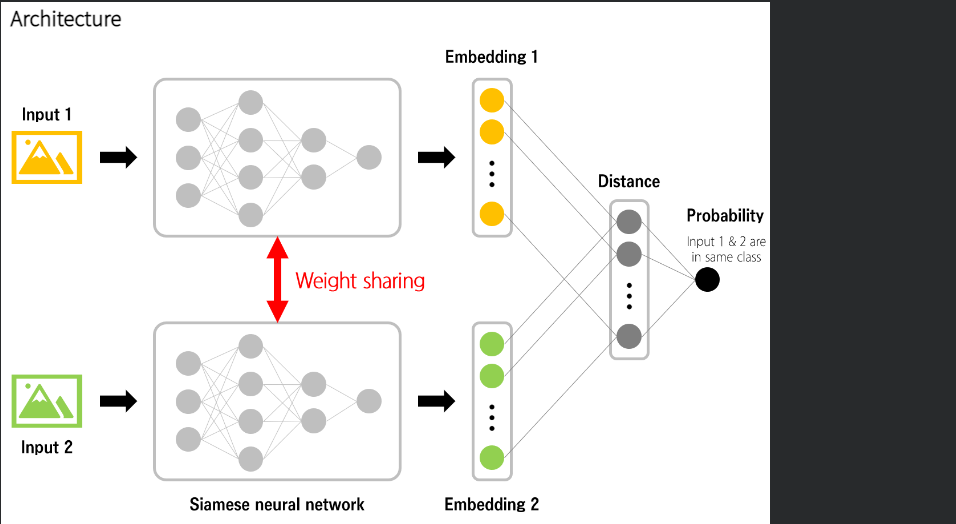

In [29]:
embedding_model = SentenceTransformer("snunlp/KR-SBERT-V40K-klueNLI-augSTS")
embedding_model

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False, 'architecture': 'BertModel'})
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [30]:
# encode 실행해보기
print(summaries[0])
sample_eco = embedding_model.encode(summaries[0])
print(sample_eco)

왜 먹고 먹고만 햇는데 몸이 무겁지 걸은것도 별로 없는데 몰라여 응가싸서 그런가 고되다 똥싸서 몸무게 빠졋나 아삐건해 미틴 진짜 7-800그람 빠짐 나 몸이 너무 무거워서 몸무게 쟀는데 빠져서 놀란다
[-1.60105675e-01 -3.90785694e-01 -1.14027746e-01 -8.38059425e-01
  6.79193079e-01  2.12157279e-01  3.81538779e-01 -1.02279916e-01
  3.37523937e-01 -1.09835938e-01  4.68984097e-01  2.05641016e-01
  1.94745108e-01  2.22256809e-01 -6.12541318e-01 -8.01862121e-01
 -1.32781684e-01 -1.35939255e-01 -1.22464612e-01  7.24541783e-01
 -1.07890701e+00 -3.34690452e-01 -6.38175309e-02  1.04309952e+00
  9.39392969e-02 -2.95117617e-01 -1.02880538e+00 -2.81762034e-01
 -2.58084387e-01  9.37179253e-02  9.96884480e-02  2.22877264e-02
 -4.95228887e-01 -1.82810187e-01  1.06831598e+00  5.52906990e-01
 -5.14801085e-01  1.97820649e-01 -3.41827482e-01  8.33667815e-01
  8.29819292e-02  5.89786172e-01 -6.31342316e-03 -5.38088977e-01
  3.25177275e-02 -8.11390698e-01  5.23242474e-01  5.15659690e-01
  5.02905548e-02  8.66454184e-01  6.12981141e-01  9.98513460e-01
  1.85657084e-01 -7.73863435e-01 -2.5713580

## 4. 토픽모델링(BERTopic 적용)
- 4.1) 원문 기반 토픽 모델링 적용
- 4.2) 요약문 기반 토픽 모델링 적용
- 문서 집합 내에서 숨겨진 주제나 토픽을 찾아내는 텍스트 마이닝 기법 적용
- 기계학습 및 자연어 처리 분야에서 널리 사용되며, 문서를 분석하여 어떤 주제를 포함하고 있는지 확인을 할 수 있는 기술(방법)
- 원문 vs 요약 비교

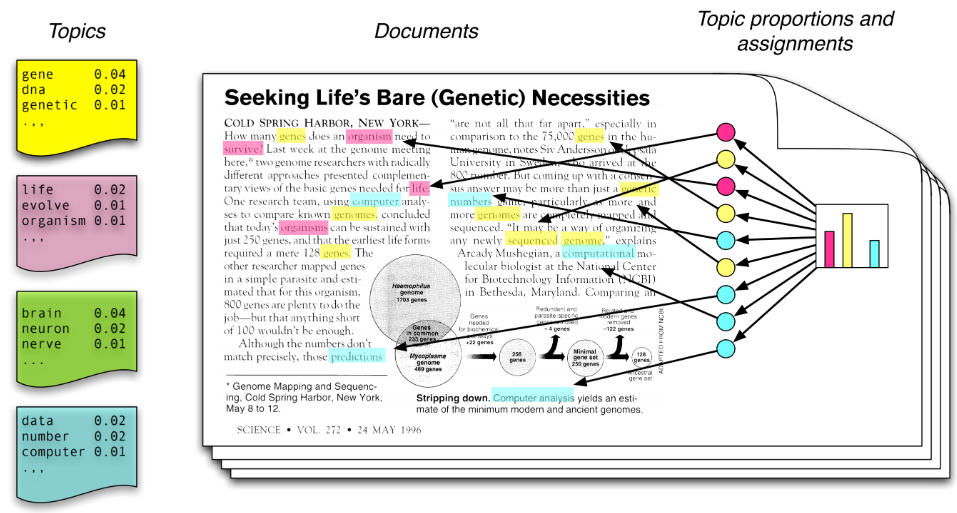

#### BERTopic
- Transformer 기반 임베딩(BERT 등)과 군집화 기법(HDBSCAN)을 결합한 토픽 모델링 기법
- 임베딩된 문서를 UMAP으로 차원 축소 후, HDBSCAN(또는 KMeans)으로 클러스터링 수행
- 각 클러스터의 대표 키워드를 추출하여 토픽을 해석하기 용이하게 함
- 전통적 LDA처럼 단어 빈도만 보는 게 아니라, 문장·문서 간 의미적 유사성을 반영

> LDA (Latent Dirichlet Allocation)
> - 자연어 처리에서 문서에 내재된 주제를 파악하는 확률적 토픽 모델링 기법
> - 빈도수만을 활용하며, Topic의 개수를 Coherence(주제 일관성) & Perplexity(혼란도) 등을 활용하여 수동 설정 필요

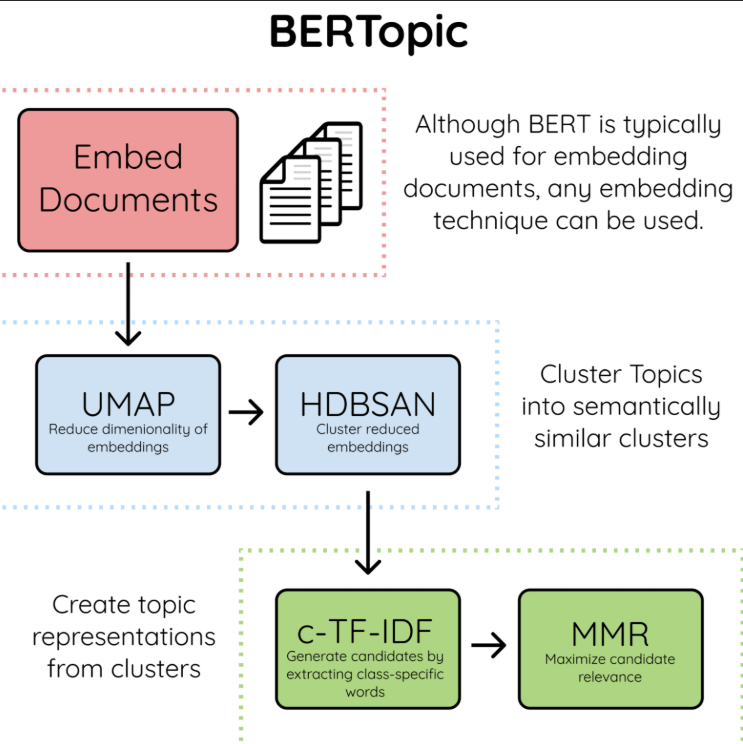

#### BERTopic 주요 구성요소

> ##### 문서 임베딩(Embed Documents)
> - 입력된 문서(문장, 단락 등)를 BERT 계열 모델로 768차원 이상의 실수 벡터로 변환
> - 의미론적 유사성을 벡터 간 거리로 표현할 수 있도록 함

> ##### 차원 축소 (UMAP, Uniform Manifold Approximation and Projection)
> - 고차원(768차원)의 임베딩을 2~5차원 정도로 줄여 계산·시각화 효율 개선
> - 유사한 벡터는 가깝게, 먼 벡터는 멀게 배치
> - 차원 축소 알고리즘 중 하나 (가장 좋은 성능을 내는 알고리즘이라고 알려짐, https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6)

> ##### 밀도 기반 군집화 (HDBSCAN, Hierarchical Density-Based Spatial Clustering of Applications with Noise)
> - DBSCAN의 단점을 보완해 **계층적(hierarchical)** 구조로 확장
> - UMAP으로 축소된 벡터 공간에서 “문서 간 밀도 차이”를 이용해 클러스터(토픽) 자동 판단
> - 노이즈(어느 클러스터에도 속하지 않는 문서)도 함께 걸러냄

> ##### 토픽 키워드 생성(c-TF-IDF, class-based TF-IDF)
> - document들로 클러스터링 된 군집들에 대하여 TF-IDF의 개념을 적용하기 위해 변형된 형태
> - 클러스터별로 속한 문서들을 하나의 가상 문서(corpus)로 보고
> - 그 내부에서 TF-IDF를 계산해 “해당 토픽을 대표할 키워드” 추출

> ##### 결과 정제(MMR, 선택적)
> - 키워드 후보 중 중복을 줄이고 다양성을 높이기 위해 MMR(Maximal Marginal Relevance) 적용
> - 중요 키워드를 균형 있게 선별

- 원본 vs 요약 비교 : 직접 차이를 비교

In [31]:
!pip -q install --upgrade bertopic

# --upgrade : 최신본 설치 요구
# bertopic : BERTopic 패키지 설치 이름

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 5.4 MB/s eta 0:00:00


In [32]:
from bertopic import BERTopic # BERTopic 토픽 모델링 클래스

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


- 4.1)원문 기반 토픽 모델링 수행

In [33]:
# train_corpus
# 토픽 모델 정의
topic_model_orig = BERTopic(
    embedding_model = embedding_model, # SBERT 임베딩 모델 객체
    calculate_probabilities = True,    # 무서별 토픽 확률을 계산 설정
    verbose = True                     # 학습 중 상세 로그 출력 설정
)

In [34]:
# 원문에 대해 토픽 모델링 수행
topics_orig, probs_orig = topic_model_orig.fit_transform(train_corpus)

2025-10-30 05:17:42,683 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

2025-10-30 05:17:43,018 - BERTopic - Embedding - Completed ✓
2025-10-30 05:17:43,019 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-30 05:17:50,634 - BERTopic - Dimensionality - Completed ✓
2025-10-30 05:17:50,635 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-30 05:17:50,654 - BERTopic - Cluster - Completed ✓
2025-10-30 05:17:50,666 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-30 05:17:50,698 - BERTopic - Representation - Completed ✓


In [35]:
print(topics_orig) # 문서별 할당된 토픽 번호 (-1)
print(probs_orig)  # 문서가 토픽 n에 속할 확률
# (토픽 -1은 두 열의 합이 1보다 작다면 나머지 확률만큼 노이즈일 가능성이 있다는 뜻)

[1, 0, 1, 1, 0, 0, 0, 0, 1, -1, -1, -1, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 0, -1, 1, 0, 0, 0, 1, -1, 0, 0, 0, 0, -1, 0, 0, 1, -1, 1, 0, 0, -1, 0, 0, 0, 0, -1, -1, 0, -1, 0, -1, 0, 0, -1, -1, 1, -1, -1, -1, -1, 0, 1, 0, -1, 1, -1, -1, 0, 1, 1, -1, -1, 0, -1, 0, -1, 1, 0, -1, -1, 1, 1, 0, 1, -1, 1, 0, 0, 0, -1, -1, 1, 0, 0, -1, -1, -1, -1, 1, 0, 0, -1, -1, 1, -1, 0, 0, 1, 1, -1, 1, 0, 0, 0, 1, 0, 0, 0, 0, -1, 0, -1, 1, 1, -1, -1, -1, -1, -1, -1, 0, -1, 0, -1, 0, 0, 1, 0, 1, 1, 0, 1, -1, 0, 0, 0, 1, -1, 1, 1, -1, -1, -1, -1, 1, 0, -1, 0, -1, 1, 0, -1, -1, -1, 0, 0, -1, 0, 1, -1, 0, -1, -1, -1, -1, -1, 0, 0]
[[6.22247225e-309 1.00000000e+000]
 [1.00000000e+000 4.33563363e-309]
 [1.80724937e-001 6.37478468e-001]
 [6.94186599e-309 1.00000000e+000]
 [1.00000000e+000 4.74691749e-309]
 [1.00000000e+000 5.72372544e-309]
 [7.24774530e-001 2.75225470e-001]
 [5.91538194e-001 3.68600148e-001]
 [2.88520448e-001 5.78449677e-001]
 [5.22

In [36]:
# 토픽 정보 확인
info_orig = topic_model_orig.get_topic_info()
info_orig

# Topic : 토픽 ID 번호
# Count : 해당 토픽에 할당된 문서(대화) 개수
# Name : <토픽번호>_<대표키워드조합>
# Representation : 토픽별 상위 키워드 리스트
# Representative_Docs: 해당 토픽을 대표하는 문서(대화) 샘플 리스트

,Topic,Count,Name,Representation,Representative_Docs
0,-1,78,-1_근데_이름_시스템_너무,"[근데, 이름, 시스템, 너무, 진짜, ㅋㅋㅋㅋ, ㅠㅠ, 엄청, 나도, 사진]",[너무 낮으면 높이고 프로게스테론도 마찬가지로 농도가 너무 높으면 LH 분비가 줄고...
1,0,79,0_근데_그냥_이름_진짜,"[근데, 그냥, 이름, 진짜, ㅠㅠ, 이제, 사진, 그럼, 지금, 나도]",[근데 가끔 담배때문에 머리 아플때가 있음 ㅋㅋㅋ 그럼 피면 안되지 그러니까 ㅋㅋ ...
2,1,43,1_이름_이모티콘_운동_진짜,"[이름, 이모티콘, 운동, 진짜, ㅋㅋㅋ, ㅋㅋ, 나는, 너무, 몸무게, 시스템]",[아 #@이름# 진짜 완전 애긴대 세 네살 되보여 그치만 잘생김 맞아 실제론 작담니...


In [37]:
# 전체 문서의 개수 조회
info_orig['Count'].sum() # 600

np.int64(200)

- 4.2) 요약문 기반 토픽 모델링 수행

In [38]:
# 요약 데이터 기반 BERTopic 모델 초기화(정의)
topic_model_sum = BERTopic(
    embedding_model = embedding_model,
    calculate_probabilities = True,
    verbose = True
)

In [39]:
# 요약문 대해 토픽 모델링 수행
topics_sum, probs_sum = topic_model_sum.fit_transform(summaries)

2025-10-30 05:17:50,756 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

2025-10-30 05:17:50,970 - BERTopic - Embedding - Completed ✓
2025-10-30 05:17:50,971 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-30 05:17:51,229 - BERTopic - Dimensionality - Completed ✓
2025-10-30 05:17:51,230 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-30 05:17:51,244 - BERTopic - Cluster - Completed ✓
2025-10-30 05:17:51,248 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-30 05:17:51,265 - BERTopic - Representation - Completed ✓


In [40]:
# 토픽 정보 확인
info_sum = topic_model_sum.get_topic_info()
info_sum
# - 원본 생성된 토픽과 비교

,Topic,Count,Name,Representation,Representative_Docs
0,-1,80,-1_근데_진짜_너무_그냥,"[근데, 진짜, 너무, 그냥, 제일, 그래도, 사랑니, 응응, 오늘, 하면]",[나는 원래 하체 말랐었는데 근데 누나 근육도 많긴하지만 통뼈지 아니 뼈는 걍 쏘쏘...
1,0,86,0_근데_나도_빨리_진짜,"[근데, 나도, 빨리, 진짜, 이름, 수도, 나는, 아니, 너무힘둘더랑, 있고]",[가을이 되면 단발을 하고 싶은데 후회 천퍼 할 구 알아서 그냥 있는다..........
2,1,20,1_빼고_너무_15분_몸무게,"[빼고, 너무, 15분, 몸무게, 운동, 나는, 많은, 무시하냐, 빠짐, 안에]",[요즘 허벅지 살이 줄어든 것 같아 허벅지랑 배랑 엉덩이랑 팔 빼고 다 빼고 싶단 ...
3,2,14,2_사랑해_오늘_많이_3부,"[사랑해, 오늘, 많이, 3부, 들우꾸야, 내일부터, 내꺼, 놀다, 드세요, 오한]",[오늘 동기애들과 놀다 들우꾸야 피임약 그대로 먹고 있눈데 오늘 동기애들이랑 놀다 ...


In [41]:
# 0번 토픽별 상위 키워드 리스트 출력
info_sum['Representation'][1]

['근데', '나도', '빨리', '진짜', '이름', '수도', '나는', '아니', '너무힘둘더랑', '있고']

In [42]:
# 0번 토픽별 상위 키워드 리스트 + cTFIDF 점수 (높을수록 해당 토픽을 잘 나타내는 키워드라는 의미)
topic_model_sum.get_topic(0)

# 0번 토픽의 키워드는 해당 토픽에 대한 연관성(대표성)이 생각보다 높지는 않음

# 요약문 기반에서 조금 더 정제되어 토픽 해석이 원문보다는 직관적임
# 특히 중복되는 불용어(의미없는 단어, ex. "시스템" 등) 줄어든 것이 확인 됨

[('근데', np.float64(0.03142859499008614)),
 ('나도', np.float64(0.02367767361488505)),
 ('빨리', np.float64(0.023124191687811383)),
 ('진짜', np.float64(0.021232149115387136)),
 ('이름', np.float64(0.01941502201537911)),
 ('수도', np.float64(0.01871998587826122)),
 ('나는', np.float64(0.018415968367132815)),
 ('아니', np.float64(0.018203968833574436)),
 ('너무힘둘더랑', np.float64(0.016685504993665567)),
 ('있고', np.float64(0.016096987197353214))]

- 원문 vs 요약 토픽별 대표 키워드

In [43]:
# 원문 토픽별 대표 키워드
# -1 토픽은 noise값으로 제외하고 확인
for t in info_orig.Topic.unique():
  if t == -1: # 노이즈
    continue
  print(f"\n[원문 토픽 {t}] 키워드")
  display(topic_model_orig.get_topic(t))


[원문 토픽 0] 키워드


[('근데', np.float64(0.04297827434408427)),
 ('그냥', np.float64(0.02979110900088243)),
 ('이름', np.float64(0.026013945207578996)),
 ('진짜', np.float64(0.02592112545626162)),
 ('ㅠㅠ', np.float64(0.024160700426151347)),
 ('이제', np.float64(0.021491096992430507)),
 ('사진', np.float64(0.018523448639465725)),
 ('그럼', np.float64(0.018184774378210432)),
 ('지금', np.float64(0.017242190218936013)),
 ('나도', np.float64(0.017111318545532772))]


[원문 토픽 1] 키워드


[('이름', np.float64(0.045628219659771055)),
 ('이모티콘', np.float64(0.04429764588561275)),
 ('운동', np.float64(0.04352444714671087)),
 ('진짜', np.float64(0.04030175261884531)),
 ('ㅋㅋㅋ', np.float64(0.03599183728206036)),
 ('ㅋㅋ', np.float64(0.027470175783251314)),
 ('나는', np.float64(0.025467488349763534)),
 ('너무', np.float64(0.024917425810657173)),
 ('몸무게', np.float64(0.022819151044487465)),
 ('시스템', np.float64(0.022304023909234045))]

In [44]:
# 요약본 토픽별 대표 키워드
# -1 토픽은 noise값으로 제외하고 확인
for t in info_sum.Topic.unique():
  if t == -1: # 노이즈
    continue
  print(f"\n[요약본 토픽 {t}] 키워드")
  display(topic_model_sum.get_topic(t))


[요약본 토픽 0] 키워드


[('근데', np.float64(0.03142859499008614)),
 ('나도', np.float64(0.02367767361488505)),
 ('빨리', np.float64(0.023124191687811383)),
 ('진짜', np.float64(0.021232149115387136)),
 ('이름', np.float64(0.01941502201537911)),
 ('수도', np.float64(0.01871998587826122)),
 ('나는', np.float64(0.018415968367132815)),
 ('아니', np.float64(0.018203968833574436)),
 ('너무힘둘더랑', np.float64(0.016685504993665567)),
 ('있고', np.float64(0.016096987197353214))]


[요약본 토픽 1] 키워드


[('빼고', np.float64(0.07441340034988134)),
 ('너무', np.float64(0.06539925752392167)),
 ('15분', np.float64(0.05879446194920618)),
 ('몸무게', np.float64(0.05581005026241101)),
 ('운동', np.float64(0.053497900385940225)),
 ('나는', np.float64(0.04217585612651399)),
 ('많은', np.float64(0.04200384384786187)),
 ('무시하냐', np.float64(0.04200384384786187)),
 ('빠짐', np.float64(0.04200384384786187)),
 ('안에', np.float64(0.04200384384786187))]


[요약본 토픽 2] 키워드


[('사랑해', np.float64(0.08959156106545703)),
 ('오늘', np.float64(0.08569062832053637)),
 ('많이', np.float64(0.07061137104670975)),
 ('3부', np.float64(0.06400585729198)),
 ('들우꾸야', np.float64(0.06400585729198)),
 ('내일부터', np.float64(0.06400585729198)),
 ('내꺼', np.float64(0.06400585729198)),
 ('놀다', np.float64(0.06400585729198)),
 ('드세요', np.float64(0.06400585729198)),
 ('오한', np.float64(0.06400585729198))]

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# Seaborn 시각화의 경우, font_manager로 직접 추가해야 한글 시각화 가능

# GULIM.TTC 경로 지정 (./data/GULIM.TTC라면 그대로 사용)
font_path = "./data/GULIM.TTC"
fm.fontManager.addfont(font_path)

# FontProperties를 통해 실제 패밀리 이름 가져오기
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()    # 예: 'Gulim'

# matplotlib 전역 설정에 등록
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

- 5.1) 토픽 분포 비교

In [46]:
# 토픽 비교용 DF 생성
df_topic_compare = pd.DataFrame({
    "original" : topics_orig,
    "summary" : topics_sum
})

In [47]:
# 원문 - 토픽별 문서 수 집계 - 인덱스(토픽 ID) 기준 정렬
orig_topic_cnt = df_topic_compare['original'].value_counts().sort_index()

# 요약 - 토픽별 문서 수 집계 - 인덱스(토픽 ID) 기준 정렬
sum_topic_cnt = df_topic_compare['summary'].value_counts().sort_index()

# 두 개의 데이터를 하나의 df 병합
# merge: 열 기준 병합, concat: 행 기준 병합 (axis 값을 설정하면 열방향 병합 가능)
df_topic_cnt = pd.concat(
    [orig_topic_cnt, sum_topic_cnt], # 병합할 두 시리즈를 리스트로 묶어서 연결
    axis = 1,
    keys = ['origin_cnt', 'sum_cnt'] # 새 df의 컬럼명 지정
).fillna(0)                          # NaN 값을 0으로 채움
df_topic_cnt

,origin_cnt,sum_cnt
-1,78.0,80
0,79.0,86
1,43.0,20
2,0.0,14


<Figure size 1000x500 with 0 Axes>

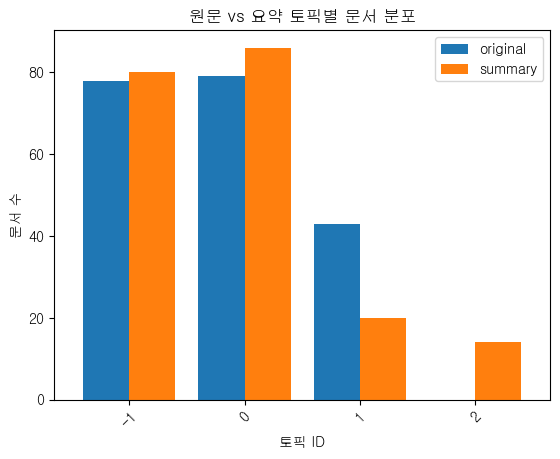

In [51]:
# 막대그래프
plt.figure(figsize=(10,5)) # x, y
df_topic_cnt.plot(kind='bar', width = 0.8) # 바 너비 지정 0.8
plt.title("원문 vs 요약 토픽별 문서 분포")
plt.xlabel("토픽 ID")
plt.ylabel("문서 수")
plt.xticks(rotation = 45)
plt.legend(["original", "summary"]) # 범례 이름 설정
plt.show()

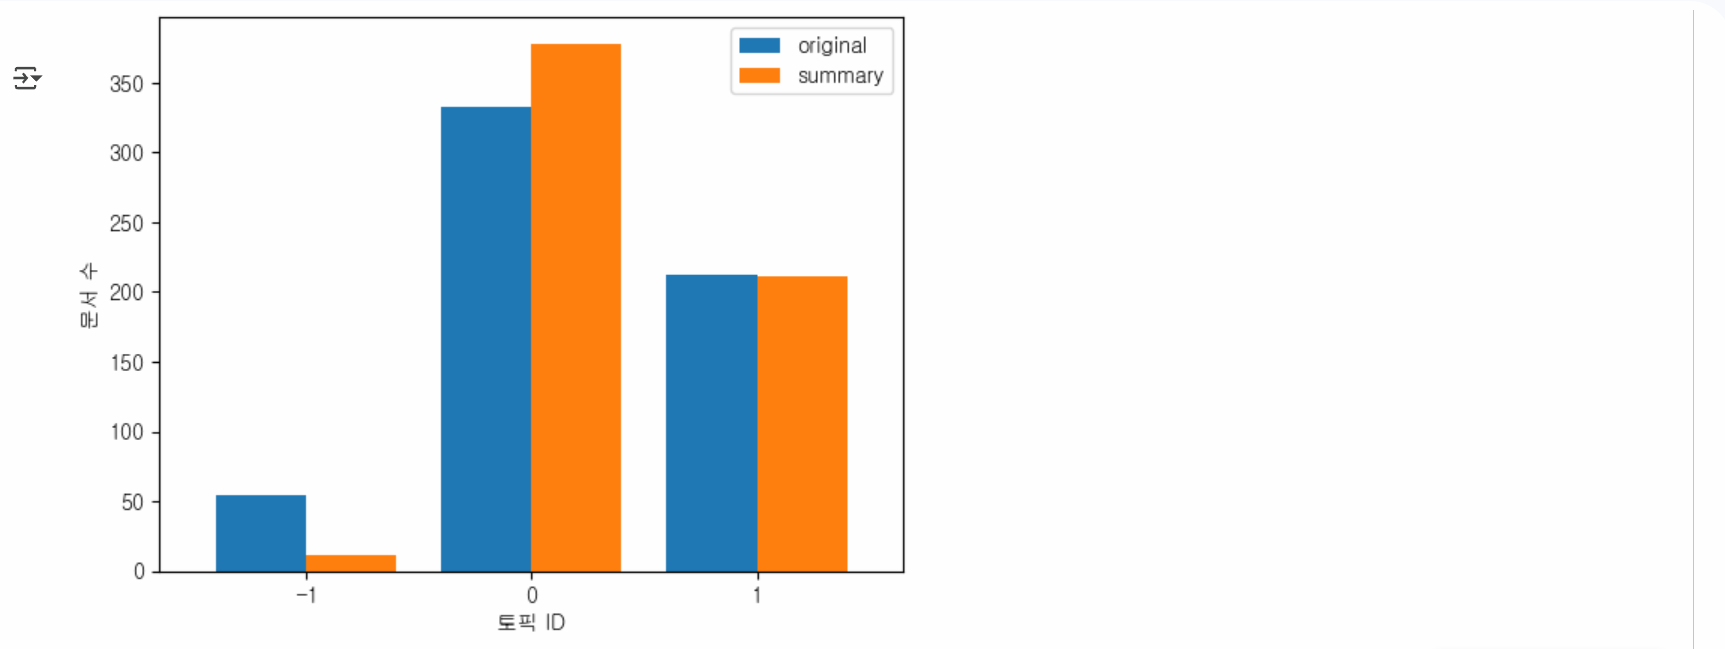

In [ ]:
# Barchart 해석
# 노이즈(-1) 토픽 감소
# - 요약 과정에서 의미가 모호했거나 노이즈 상태의 대화 내용이 제거 되면서 문장을 더 명확하게 생성했기에
# - 노이즈 값은 다른 토픽으로 이동한 거으로 보임

# 토픽 0 증가
# - -1 노이즈 원문 문장의 내용이 보다 복잡했기 때문에 높았지만, 요약한 이후에는 0번 토픽과
# -더 맥락상 비슷하기 때문에 이동한 것으로 보임

# 토픽 1 비슷함
# - 기존의 핵심 주제어와 크게 차이가 나지 않는 것으로 보임

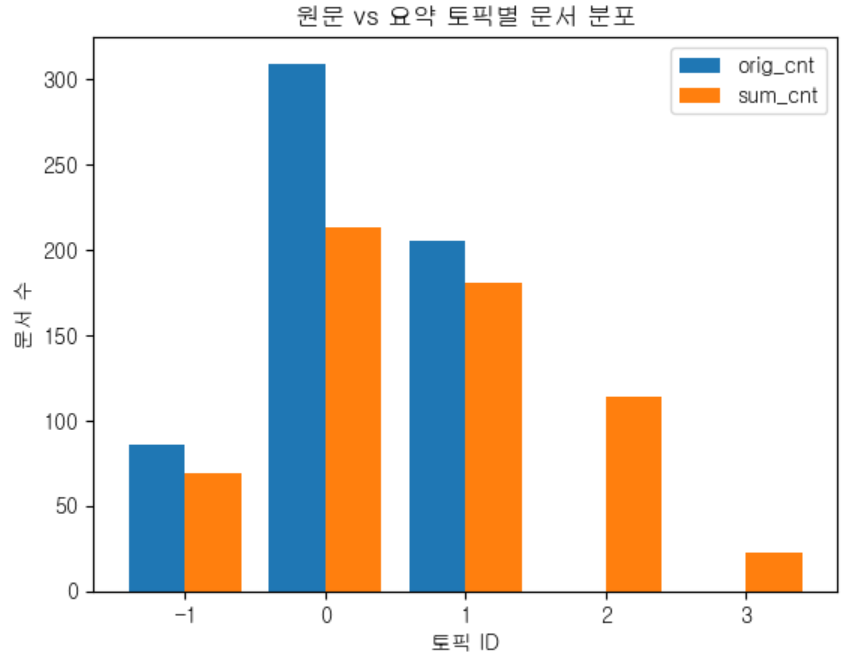

In [ ]:
# 주황색 그래프(요약 그래프)
# - 요약 후에 새롭게 토픽이 생성되고, 노이즈 내용이 제거되면서 전체적인 문서의 군집 위치가 이동됨을 알 수 있
# - 전체적으로 살펴봤을 때, 데이터가 여러 토픽으로 분산은 많이 되었지만
# - 한 개의 토픽 안에서의 응집력은 높아젺을 가능성이 높음

- 5.2) 토픽별 대표 키워드 & 대표 문장 파악

In [53]:
# 원문(original)과 요약(summary)에서 사용된 최대 토픽 ID를 계산
max_topic = max(df_topic_compare['original'].max(), df_topic_compare['summary'].max())
max_topic

2

In [54]:
# 해당 토픽 t가 원문 또는 요약 모델의 토픽 정보에 없으면 건너뜀
for t in range(0, max_topic + 1):
  if t not in topic_model_orig.get_topic_info()["Topic"].values or t not in topic_model_sum.get_topic_info()["Topic"].values:
    continue
  print(f"\n=== 토픽 {t} ===")
  print("원문 키워드 :", [w for w, _ in topic_model_orig.get_topic(t)[:5]]) # 원문 기반 토픽 t의 상위 5개 키워드 추출 및 출력
  print("요약 키워드 :", [w for w, _ in topic_model_sum.get_topic(t)[:5]])  # 요약 기반 토픽 t의 상위 5개 키워드 추출 및 출력
  print("원문 대표문장:", topic_model_orig.get_representative_docs(t)[:2])  # 원문 모델에서 토픽 t를 대표하는 문장 상위 2개 출력
  print("요약 대표문장:",  topic_model_sum.get_representative_docs(t)[:2])  # 요약 모델에서 토픽 t를 대표하는 문장 상위 2개 출력


=== 토픽 0 ===
원문 키워드 : ['근데', '그냥', '이름', '진짜', 'ㅠㅠ']
요약 키워드 : ['근데', '나도', '빨리', '진짜', '이름']
원문 대표문장: ['근데 가끔 담배때문에 머리 아플때가 있음 ㅋㅋㅋ 그럼 피면 안되지 그러니까 ㅋㅋ 근데 안 필수가 없지 ㅋㅋㅋ 잉... 그냥 끊어 ㅋㅋ', '#@이름#아 떙이돌 오늘 받으러 가 근데 땡이돌 건조하대 그래서 여름에 좋나봐 나는 뭐 상관없지만.. 근데 또 뭐 여러개 바르면 괜찮은거 같아 마자 여름에 발랐을 때 내가 너네한테 건조하다고 했어 근데 크림을 하나 덜 바르고 발랐던거라서 그랬을 수 있고 아 고터까지가기 귀차나..ㅠㅠ 갓는데 색도 이상한거주면억케... 가서 너는 bo01해도 될거 같아 옐로베이스야 너 원래 옐로 베이스 쓰잖아 그지? 그니까 가서 저 혹시 bo01로 주시면 안될까여... 하면 주지 않을까 어차피 그게 주력 컬러던데 그게 색별로 잇으려나.. 주력컬러는 있을걸']
요약 대표문장: ['가을이 되면 단발을 하고 싶은데 후회 천퍼 할 구 알아서 그냥 있는다....... 나도 근데 가을되면 단발 하고 싶은데 과연 후회 천퍼 할 구 알아서 그냥 있는다.......', '엄마한테 가격 말햇다가 근데 진짜 개에바다 330이면 #@이름#이 눈하고 코까지 할듯 엄마가 긁어줘야할 돈은 270인대 말햇다가 왜 거기서만 상담받냑 그니까 혼날일햇네 뭐라뭐라 들엇머 딴데도 가봐야지 멍충아 악!! 근데 지금 딴데도 가봐야하나 이지랄떨고잇는중 엄마한테 먼 잔소리를 들을까?']

=== 토픽 1 ===
원문 키워드 : ['이름', '이모티콘', '운동', '진짜', 'ㅋㅋㅋ']
요약 키워드 : ['빼고', '너무', '15분', '몸무게', '운동']
원문 대표문장: ['아 #@이름# 진짜 완전 애긴대 세 네살 되보여 그치만 잘생김 맞아 실제론 작담니다 #@이모티콘#흑흑# ㅋㅋㅋ 완전 꼬맹인댕 학원옴 빠르네????? 완전 열심히 왓더니 가깝나바ㅋㅋㅋㅋ 더움 ㅋㅋㅋ 부천역 ㅋㅋ 걸어댕기는데 오늘

## 6. 요약본(summaries) 기반 토픽별 감성 분석
- **요약본으로 클러스터링된 각 토픽**에 대해 문서별 감성(긍정/중립/부정) 분포를 파악
- 서비스 관점에서 ‘어떤 주제에 부정적 반응이 많은가?’, ‘어떤 주제에 긍정적인지?’ 등을 시각화하여 **토픽 × 감성 상관관계**를 분석해볼 수 있음

In [ ]:
# !pip install transformers[torch]

In [55]:
from transformers import pipeline

#### 감정 라벨링용 모델 (KoELECTRA-v3 NSMC)
- **모델명**: `daekeun-ml/koelectra-small-v3-nsmc`  
- **파인튜닝 데이터**: Naver Sentiment Movie Corpus (NSMC)  
- **태스크**: 감성 분석 (binary classification, sentiment-analysis)  
- **최대 입력 길이**: 512 토큰  
- **출력 라벨**:  
  - `0` → negative  
  - `1` → positive

In [57]:
# 감성분석 모델 파이프라인 코드로 불러오기
# 과제, 모델명, gpu 장치
# 변수 sentiment_analyzer
sentiment_analyzer = pipeline(
    task = "sentiment-analysis",
    model = "daekeun-ml/koelectra-small-v3-nsmc",
    tokenizer = "daekeun-ml/koelectra-small-v3-nsmc",
    device = 0
)

model.safetensors:   0%|          | 0.00/56.5M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
from tqdm.auto import

In [74]:
# 토픽 할당된 요약본에 대해 감성 예측
# topic 0 - 긍정? 부정?
sentiments = [] # 예측 결과 문자열을 담을 리스트 변수

for doc in tqdm(summaries, desc = "sentiment analysis..."):
  result = sentiment_analyzer(doc[:512])[0] # bert 모델/t5 모델 포지션 임베딩 길이 512

  # 'label' 값만 활용, 0: 'negative', 1: 'positive' -> 삼항연산자로 처리
  sent_label = 'negative' if result['label'] == 0 else 'positive'
  sentiments.append(sent_label)

sentiment analysis...:   0%|          | 0/200 [00:00<?, ?it/s]

In [75]:
print(sentiments)

['positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'po

In [76]:
# 토픽 ID와 감성 레이블을 하나의 DF 병합
# topics_sum, sentiments
df_topic_sent = pd.DataFrame({
    "topic": topics_sum, # 앞서 요약문 기반으로 할당된 토픽 ID 리스트
    "sentiment": sentiments
})
df_topic_sent.groupby(by = 'topic').value_counts()

,,count
topic,sentiment,
-1,positive,80
0,positive,86
1,positive,20
2,positive,14


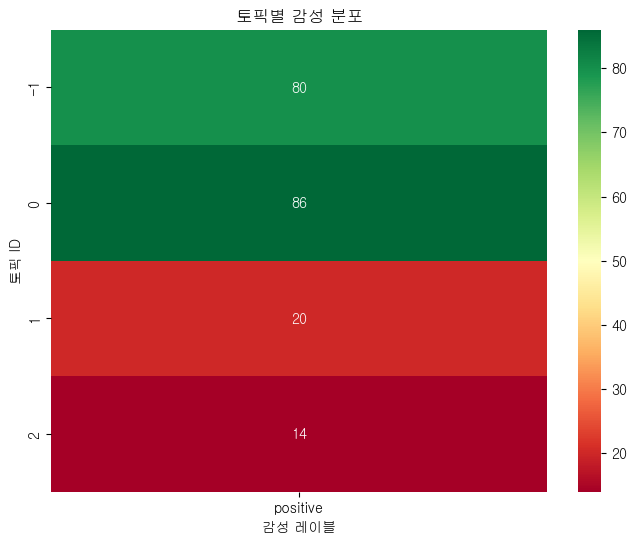

In [77]:
# 토픽X감성 분포 계산
ct = pd.crosstab(df_topic_sent['topic'], df_topic_sent['sentiment'])

# 데이터의 밀도, 분포를 한눈에 파악할 수 있는 그래프 - 히트맵
plt.figure(figsize = (8, 6))
sns.heatmap(ct, annot = True, fmt = "d", cmap = "RdYlGn")
plt.title("토픽별 감성 분포")
plt.xlabel("감성 레이블")
plt.ylabel("토픽 ID")
plt.show()

<Figure size 800x600 with 0 Axes>

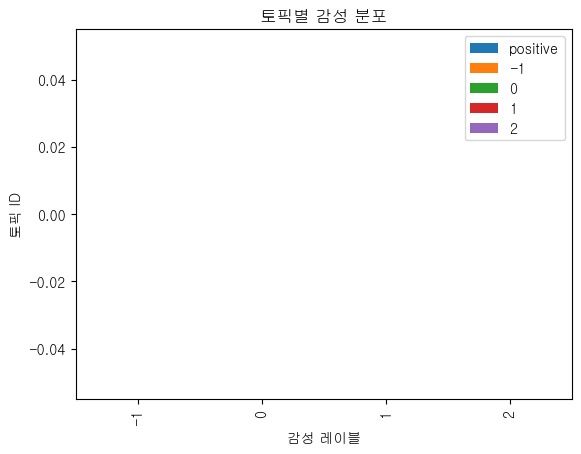

In [78]:
# 비율 막대 그래프 ( 누적 막대 그래프)
plt.figure(figsize = (8, 6))
# div : 카테고리별 비율을 출력하는 기능
ct.div(ct.sum(axis = 1)).plot(kind = 'bar', stacked = True)
plt.title("토픽별 감성 분포")
plt.xlabel("감성 레이블")
plt.ylabel("토픽 ID")
plt.show()

In [80]:
ct.div(ct.sum(axis = 1), axis = 0)

sentiment,positive
topic,
-1,1.0
0,1.0
1,1.0
2,1.0


#### Fine Tuning

> 이제껏 사전학습 된 모델로 Task를 수행해봤음
> - Hugging Face 허브(저장소)에서 해당 데이터로 미리 학습된 모델을 찾을 수 있다면 간단히 활용할 수 있음

> 사전학습된 언어모델은 어느정도 여러 Task 작업이 가능함
> - 특별한 학습 과정 없이 바로 작업이 가능하다는 점에서 흥미롭지만,
> - 보다 정확한 결과를 위해서는 해당 과제로 **<U>파인튜닝된 모델이 있는 편이 좋음**</U>

#### 기본 구조를 익혔으니, FineTuning 방법에 대해서도 배워보자!